In [1]:
!python3 --version

Python 3.7.16


In [2]:
import torch
torch.cuda.set_device(5)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 5
Current default GPU name: NVIDIA A40


In [3]:
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
from diffusers.utils import load_image

import torch

pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")


The config attributes {'feature_extractor': [None, None], 'image_encoder': [None, None]} were passed to StableDiffusionXLImg2ImgPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'feature_extractor': [None, None], 'image_encoder': [None, None]} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "force_zeros_for_empty_prompt": true,
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_side_by_side(image_paths, captions):
    # Number of images
    n = len(image_paths)
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(1, n, figsize=(4, 2))  # Adjust figure size as needed
    
    # Loop through images, their axes, and captions
    for ax, img_path, caption in zip(axes, image_paths, captions):
        # Load and display the image
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        
        # Set the caption
        ax.set_title(caption, fontsize=10, pad=10)  # Adjust font size and padding as needed
        
    plt.tight_layout()
    plt.show()

In [36]:
integer_to_name[3]

'bear'

In [ ]:
extract_prompts_fromtxts

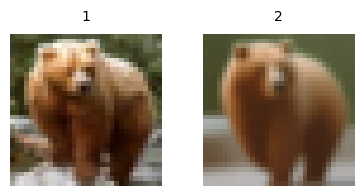

In [37]:
image_name = 'bear10.png'
img_path1 = 'saved_data/llava_saved_data_310/cifar_50/' + image_name
img_path2 = 'saved_data/real_sythesis_cifar100_llava_i2i_3real/' + image_name

image_paths = [img_path1, img_path2]
display_images_side_by_side(image_paths, [1,2])

  0%|          | 0/5 [00:00<?, ?it/s]

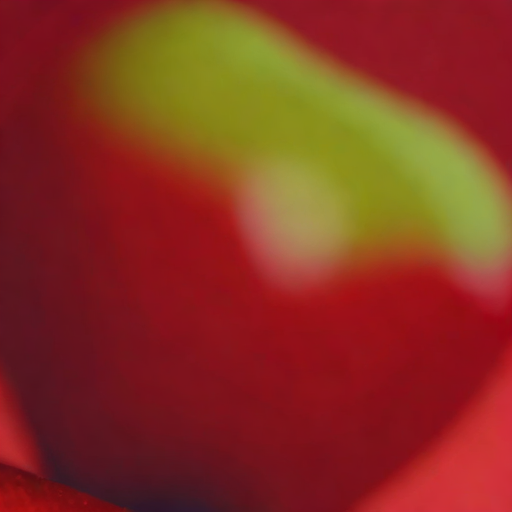

In [25]:

generator1 = torch.Generator(device="cuda").manual_seed(42)

pmt = 'The image features a close-up of a red apple with a green stem, sitting on top of a red background. The apple is the main focus of the image, and its vibrant red color contrasts with the red background. The overall mood of the image is fresh and natural, as the apple represents a healthy and natural food choice.'
img = load_image(img_path1).resize((512, 512))
image = pipe(prompt= pmt,
             image = img, 
             strength = 0.5, 
             num_inference_steps=10, 
             generator = generator1, 
             guidance_scale=1.5
            ).images[0]
image

## image generation with sdxl_turbo

In [18]:
# dataset
import torchvision

from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [19]:
# !pip install torchvision

In [20]:
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True)

name_list = trainset.classes

integer_to_name = {i: name for i, name in enumerate(name_list)}


Files already downloaded and verified


In [21]:
benchmark = SplitCIFAR100(n_experiences=20,
                          seed = 41,             
                          )

Files already downloaded and verified
Files already downloaded and verified


In [22]:
orders = benchmark.classes_order
order_list = [orders[x:x+5] for x in range(0, len(orders), 5)]
order_list

[[36, 0, 54, 5, 20],
 [22, 45, 13, 83, 19],
 [26, 73, 16, 62, 33],
 [34, 98, 24, 74, 53],
 [10, 94, 51, 4, 32],
 [38, 81, 50, 40, 41],
 [30, 89, 69, 64, 21],
 [84, 14, 88, 49, 68],
 [6, 80, 57, 65, 46],
 [9, 91, 48, 72, 31],
 [76, 7, 47, 8, 1],
 [61, 75, 63, 18, 86],
 [59, 70, 43, 85, 95],
 [27, 93, 35, 25, 82],
 [44, 56, 67, 66, 37],
 [60, 11, 2, 78, 52],
 [97, 39, 55, 3, 99],
 [29, 71, 23, 28, 90],
 [87, 15, 92, 17, 77],
 [12, 42, 96, 79, 58]]

In [23]:
order_sample = [order[0:3] for order in order_list]
classname_list = []
label_list = []
classname_list_sep = []
for order_l in order_sample:
    label_list.append(order_l)
    cur_classname = [integer_to_name[i] for i in order_l]
    classname_list.append(cur_classname)
classname_list_sep = [item for lists in classname_list for item in lists]
label_list_sep = [item for lists in label_list for item in lists]

In [24]:
len(label_list_sep)

60

In [25]:
# prompts_list = [
#         "A black and white image of [concept] highlighting dramatic contrasts.",
#         "A minimalist image of [concept] using clean lines and muted colors.",
#         "A photo of [concept] in analogous colors.",
#         "A photo of [concept] in complementary colors.",
#         "A photo of [concept] in earth tones.",
#         "A photo of [concept] in neutral tones.",
#         "This is an image of the [concept].",
#         "A realistic image of [concept].",
#         "A vintage photograph of [concept] with a warm, faded aesthetic.",
#         "A high-resolution photo of [concept] capturing fine details."
#     ]
# len(prompts_list)

In [38]:
import random

def extract_prompts_fromtxts(file_path):
    prompts = []  # List to hold the prompts
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() != 'USER':  # Ignore lines that are just 'USER'
                # Split the line at the first colon and strip whitespace from the prompt
                parts = line.split(':', 1)
                if len(parts) > 1:
                    prompt = parts[1].strip()
                    prompts.append(prompt)
    return prompts


def create_sdxl_data_fixed_prompts_randommultiple(class_dict, image_size, prompt_file_dict, generator_seed, num_image_replay=50, folder_name="/content/sd_images"):
    # Create the folder if it doesn't exist
    random.seed(42)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist
        prompt_file_path = os.path.join(prompt_file_dict, f"class{id}.txt")
        current_prompt_list = extract_prompts_fromtxts(prompt_file_path)
        
        indices = [random.randint(0, len(current_prompt_list)-1) for _ in range(num_image_replay)]
        current_prompt_list = [current_prompt_list[item] for item in indices]

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(current_prompt_list):
                print(prompt)
                image_name = class_name + f"{j}.png"
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt, generator = generator_seed, num_inference_steps=1, guidance_scale=1.0).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")


def create_sdxl_data_fixed_prompts(class_dict, image_size, prompt_file_dict, generator_seed, num_image_replay=50, folder_name="/content/sd_images"):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist
        prompt_file_path = os.path.join(prompt_file_dict, f"class{id}.txt")
        current_prompt_list = extract_prompts_fromtxts(prompt_file_path)

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(current_prompt_list):
                print(prompt)
                image_name = class_name + f"{j}.png"
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=1.0).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")
                
                
                
def create_sdxl_data_fixed_prompts_randommultiple_img2img(class_dict, image_size, prompt_file_dict, startimage_file_path,
                                                          generator_seed, num_image_replay=50, folder_name="/content/sd_images"):
    
    """
    not done, todo: provide image list as current_prompt_list
    """
    # Create the folder if it doesn't exist
    random.seed(42)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist
        prompt_file_path = os.path.join(prompt_file_dict, f"class{id}.txt")
        current_prompt_list = extract_prompts_fromtxts(prompt_file_path)
        
        
        indices = [random.randint(0, len(current_prompt_list)-1) for _ in range(num_image_replay)]
        current_prompt_list = [current_prompt_list[item] for item in indices]

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(current_prompt_list):
                print(prompt)
                image_name = class_name + f"{j}.png"
                starting_image_path = os.path.join(startimage_file_path, image_name)
                
            
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt, generator = generator_seed, num_inference_steps=1, guidance_scale=1.0).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")

In [27]:
def create_sdxl_data_img2img_matching_image_prompt(class_dict, image_size, prompt_file_dict, startimage_file_path,
                                                          generator_seed, num_image_replay=50, folder_name="/content/sd_images"):
    
    """
    this is specified to matching pair of lavva prompt and images
    """
    # Create the folder if it doesn't exist
    random.seed(42)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist
        prompt_file_path = os.path.join(prompt_file_dict, f"class{id}.txt")
        current_prompt_list = extract_prompts_fromtxts(prompt_file_path)

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(current_prompt_list):
                print(prompt)
                image_name = class_name + f"{j}.png"
                
                starting_image_path = os.path.join(startimage_file_path, image_name)
                init_image = load_image(starting_image_path).resize((512, 512))

            
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt,image = init_image, 
                                strength = 0.5, 
                                num_inference_steps=4, 
                                generator = generator_seed, guidance_scale=0.5).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")

In [28]:
def create_sdxl_llava_random(class_dict, image_size, generator_seed, num_image_replay=50, prompt_folder = "saved_data/llava_saved_data_310/llava_prompt_50", folder_name="/content/sd_images"):
    random.seed(42)
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist

        indices = [random.randint(0, 9) for _ in range(num_image_replay)]  # Assuming there are 10 prompts
        prompts = generate_prompts(class_name, indices)

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(prompts):
                print(prompt)
                image_name = class_name + f"{j}.png"
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=1.0).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")



In [29]:
import os
import random

def generate_prompts(concept, indices):
    prompts_list = [
        "A black and white image of a real [concept] highlighting dramatic contrasts.",
        "A minimalist image of a real [concept] using clean lines and muted colors.",
        "A photo of a real [concept] in analogous colors.",
        "A photo of a real [concept] in complementary colors.",
        "A photo of a real [concept] in earth tones.",
        "A photo of a real [concept] in neutral tones.",
        "This is an image of the [concept].",
        "A realistic image of a real [concept].",
        "A vintage photograph of a real [concept] with a warm, faded aesthetic.",
        "A high-resolution photo of a real [concept] capturing fine details."
    ]
    
    
    # Replace [concept] with the actual concept name
    prompt = [prompts_list[item] for item in indices]
    
    return [pt.replace("[concept]", concept) for pt in prompt]

def create_sdxl_data(class_dict, image_size, generator_seed, num_image_replay=50, folder_name="/content/sd_images"):
    random.seed(42)
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id, class_name in class_dict.items():
        print("Generating images for class " + str(id) + ": " + class_name)

        class_file_path = os.path.join(folder_name, f"class{id}.txt")
        existing_images_count = 0

        # Check how many images already exist for the class
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist

        indices = [random.randint(0, 9) for _ in range(num_image_replay)]  # Assuming there are 10 prompts
        prompts = generate_prompts(class_name, indices)

        # Generate the new images
        with open(class_file_path, "a") as file:
            for j, prompt in enumerate(prompts):
                print(prompt)
                image_name = class_name + f"{j}.png"
                image_path = os.path.join(folder_name, image_name)
                new_image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=1.0).images[0]
                resized_image = new_image.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")



In [30]:
def create_sdxl_data_baseprompt(class_dict, image_size, generator_seed, num_image_replay = 50, folder_name =  "/content/sd_images"):

    # Create the folder
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for id in class_dict:
        class_name = class_dict[id]
        print("generating images of class " + str(id) + class_name)

        class_file_path = os.path.join(folder_name, "class" + f"{id}.txt")
        existing_images_count = 0
        if os.path.exists(class_file_path):
            with open(class_file_path, "r") as file:
                # existing_images = file.readlines()
                existing_images_count = len(file.readlines())
            num_images_to_generate = num_image_replay - existing_images_count
            
            if existing_images_count >= num_image_replay:
                print(f"Class {class_name} already contains {num_image_replay} images. Moving to the next class.")
                continue  # Move to the next class if enough images already exist
        
        prompt =  "An image of a real " + class_name
        with open(class_file_path, "a") as file:
            for j in range(existing_images_count, num_image_replay):
                image_name = class_name + f"{j}.png"
                image_path = os.path.join(folder_name, image_name)

                # generate image from stable diffusion
                re = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=1.0).images[0]

                # Resize the image
                resized_image = re.resize(image_size)

                resized_image.save(image_path)

                file.write(f"{image_path} {id}\n")

                print(f"Generated image {image_name} for class {class_name}")


In [31]:
specific_integer_to_name = {key: integer_to_name[key] for key in label_list_sep if key in integer_to_name}

In [32]:
specific_integer_to_name

{36: 'hamster',
 0: 'apple',
 54: 'orchid',
 22: 'clock',
 45: 'lobster',
 13: 'bus',
 26: 'crab',
 73: 'shark',
 16: 'can',
 34: 'fox',
 98: 'woman',
 24: 'cockroach',
 10: 'bowl',
 94: 'wardrobe',
 51: 'mushroom',
 38: 'kangaroo',
 81: 'streetcar',
 50: 'mouse',
 30: 'dolphin',
 89: 'tractor',
 69: 'rocket',
 84: 'table',
 14: 'butterfly',
 88: 'tiger',
 6: 'bee',
 80: 'squirrel',
 57: 'pear',
 9: 'bottle',
 91: 'trout',
 48: 'motorcycle',
 76: 'skyscraper',
 7: 'beetle',
 47: 'maple_tree',
 61: 'plate',
 75: 'skunk',
 63: 'porcupine',
 59: 'pine_tree',
 70: 'rose',
 43: 'lion',
 27: 'crocodile',
 93: 'turtle',
 35: 'girl',
 44: 'lizard',
 56: 'palm_tree',
 67: 'ray',
 60: 'plain',
 11: 'boy',
 2: 'baby',
 97: 'wolf',
 39: 'keyboard',
 55: 'otter',
 29: 'dinosaur',
 71: 'sea',
 23: 'cloud',
 87: 'television',
 15: 'camel',
 92: 'tulip',
 12: 'bridge',
 42: 'leopard',
 96: 'willow_tree'}

## mixed data llava multiple generation image2image

In [ ]:
generator1 = torch.Generator(device="cuda").manual_seed(42)
# create_sdxl_data_fixed_prompts_randommultiple(integer_to_name, image_size = (32,32), prompt_file_dict = 'saved_data/llava_saved_data_310/llava_prompt_50/', generator_seed = generator1, num_image_replay=50, folder_name='saved_data/sd_turbo_500images_llava_firstthreeclasses/')

create_sdxl_data_img2img_matching_image_prompt(integer_to_name, image_size = (32,32),
                                               prompt_file_dict = 'saved_data/llava_saved_data_310/llava_prompt_50/',
                                               startimage_file_path = 'saved_data/llava_saved_data_310/cifar_50/',
                                               generator_seed = generator1, num_image_replay=50, 
                                               folder_name='saved_data/test')

## mixed data llava multiple generation

In [ ]:
generator1 = torch.Generator(device="cuda").manual_seed(42)
create_sdxl_data_fixed_prompts_randommultiple(specific_integer_to_name, image_size = (32,32), prompt_file_dict = 'saved_data/llava_saved_data_310/llava_prompt_50/', generator_seed = generator1, num_image_replay=500, folder_name='saved_data/sd_turbo_500images_llava_firstthreeclasses/')

## diverse prompts

In [ ]:
generator1 = torch.Generator(device="cuda").manual_seed(41)
create_sdxl_data(specific_integer_to_name, image_size = (32,32), generator_seed = generator1, num_image_replay=500, folder_name='saved_data/sd_turbo_500images/')


## base prompt

In [ ]:
generator1 = torch.Generator(device="cuda").manual_seed(41)
create_sdxl_data_baseprompt(specific_integer_to_name, image_size = (32,32), generator_seed = generator1, num_image_replay=500, folder_name='saved_data/sd_turbo_500images_baseprompt/')


In [ ]:
import os

def count_txt_files(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return 0
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter and count files that end with .txt
    txt_files_count = sum(1 for file in files if file.endswith('.txt'))
    
    return txt_files_count

# Specify the folder path here
folder_path = 'saved_data/sd_turbo_i2i_50all'

# Call the function and print the result
count = count_txt_files(folder_path)
print(f"There are {count} .txt files in the folder.")


In [ ]:
def read_and_print_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()  # Read all lines in the file
            print(len(lines))
            for line in lines:
                print(line.strip())  # Print each line, stripping newline characters
    except FileNotFoundError:
        print(f"Error: The file at {file_path} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
file_path = 'saved_data/cifar_train500/class36.txt'
read_and_print_file(file_path)
